In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import GPy
import bayesoptlib as BO


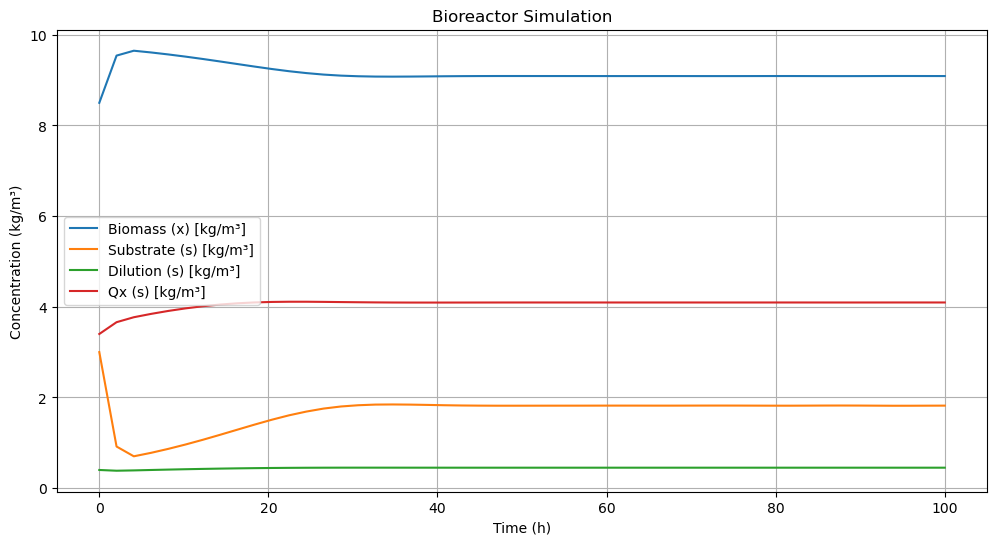

In [2]:
# Parameters based on the provided table
mu_max = 0.5       # Maximum specific growth rate (1/hr)
Y_xs = 0.5         # Biomass yield from substrate (kg/kg)
K_s = 0.2          # Substrate constant (kg/m^3)
s_in = 20.0        # Inlet substrate concentration (kg/m^3)
xsp = 9.09
Kp = -0.031/2
Ki = -0.01566/2

# Define the ODE system
def bioreactor_odes(t, y, mu_max, K_s, Y_xs, s_in,xsp):
    x, s, D = y  # Unpack state variables: biomass, substrate
    mu = mu_max * s / (K_s + s)  # Specific growth rate (Monod equation)

    # Differential equations
    dx_dt = (mu - D) * x
    ds_dt = D * (s_in - s) - (mu * x) / Y_xs
    dD_dt = Kp*dx_dt + Ki*(xsp-x) # Constraint controller

    return [dx_dt, ds_dt, dD_dt]

# Initial conditions: [biomass concentration, substrate concentration]
y0 = [8.5, 3, 0.4]  # Initial concentrations (kg/m^3)

# Time span for the simulation (0 to 50 hours)
t_span = (0, 100)
# Time points where the solution is computed
t_eval = np.linspace(t_span[0], t_span[1], 50)

# Solve the ODE system
sol = scipy.integrate.solve_ivp(
    bioreactor_odes, 
    t_span, 
    y0, 
    args=( mu_max, K_s, Y_xs, s_in,xsp), 
    t_eval=t_eval,
    method='RK45'
)

# Extract results
t = sol.t
x = sol.y[0]  # Biomass concentration
s = sol.y[1]  # Substrate concentration
D = sol.y[2]  # Substrate concentration

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(t, x, label='Biomass (x) [kg/m³]')
plt.plot(t, s, label='Substrate (s) [kg/m³]')
plt.plot(t, D, label='Dilution (s) [kg/m³]')
plt.plot(t, D*x, label='Qx (s) [kg/m³]')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (kg/m³)')
plt.title('Bioreactor Simulation')
plt.legend()

plt.grid(True)
plt.show()



In [3]:
Z_sample = np.array([xsp]).reshape(-1,1)
ZD_sample = np.concatenate((Z_sample,np.array(s_in).reshape(-1,1)),axis=1)
J_sample = np.array(-(2.2*D[-1]*x[-1])**4).reshape(1,1) # Cost

var0 = 9000
kernel_f = GPy.kern.Matern52(2,ARD = True, lengthscale=[0.2,5],variance=var0) + GPy.kern.Bias(2) 
bounds = np.array([[8.5,9.9]]) # bounds for Fb

U_range = np.linspace(bounds[:, 0].T, bounds[:, 1].T, 1000).reshape(1000,-1)


Jt = []
xt = []
Dt = []
St = []
Joptt = []
xspt = []
nIter = 30

for sim_k in range(nIter):
        
    Context = np.array([s_in]).reshape(-1,1)
    J_Obj = BO.contextual_bayesian_optimization(ZD_sample,J_sample,
                                                Context,bounds,kernel_f, X_grid = U_range)

    # Update the posterior
    J_Obj.fit_gp()
    if sim_k>=200:
       J_Obj.optimize_fit()
    J_Obj.query_next('UCB')

    x_opt = J_Obj.X_next[0][0]
    
    # system query
    y0 = [x[-1], s[-1], D[-1]]  # Initial concentrations (kg/m^3)

    # Time span for the simulation (0 to 50 hours)
    t_span = (0, 100)
    # Time points where the solution is computed
    t_eval = np.linspace(t_span[0], t_span[1], 50)

    # Solve the ODE system
    sol = scipy.integrate.solve_ivp(
        bioreactor_odes, 
        t_span, 
        y0, 
        args=( mu_max, K_s, Y_xs, s_in,x_opt), 
        t_eval=t_eval,
        method='RK45'
    )

    # Extract results
    t = sol.t
    x = sol.y[0]   # Biomass concentration
    s = sol.y[1]  # Substrate concentration
    D = sol.y[2]   # Substrate concentration
    
    Q = (2.2*D[-1]*x[-1])**4


    Jt.extend(D*x)
    xt.extend(x)
    xspt.extend(50*[x_opt])
    Dt.extend(D)
    St.extend(s)
    Joptt.extend(50*[4.095])
    #xspt.extend(xsp)
    
    Z_sample = np.vstack((Z_sample, x_opt))
    
    ZD_sample = np.vstack((ZD_sample, J_Obj.X_next))
    J_sample = np.vstack((J_sample, -Q))
    

 /Users/dkrishnamoorthy/opt/anaconda3/lib/python3.9/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


8.727504865268301 6287.642991583016
9.468881267363175 5902.972993297248
9.861948017471393 2344.0980079194646
8.5 5629.260343483685
9.277913503729895 6457.202778196895
8.908121507316356 6498.949588428299
9.659215302377394 4598.66344492527
8.612145614560536 6053.192918122612
9.183253564654567 6560.236180859144
8.99550882788934 6560.337631143706
9.373696210725058 6249.795314371125
8.817849323077834 6404.431170644319
9.134620696240857 6581.813524372686
9.043043792379509 6579.501085106151
9.105415492253368 6587.137619603831
9.0753791263267 6586.263148279105
9.095319532364806 6587.5166142056105
9.093432436941569 6587.495970198773
9.09318792029803 6587.8300815477
9.09320762283967 6587.483105956286
9.093241090897834 6587.908372077123
9.093201408614192 6587.478519053959
9.09356368700782 6587.562737285424
9.090490299912666 6587.517342204422
9.100598548300406 6587.382577274483
9.089906711242696 6587.576706589641
9.092488226000683 6587.465597323904
9.093488716634702 6587.575655468921
9.09315612873

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


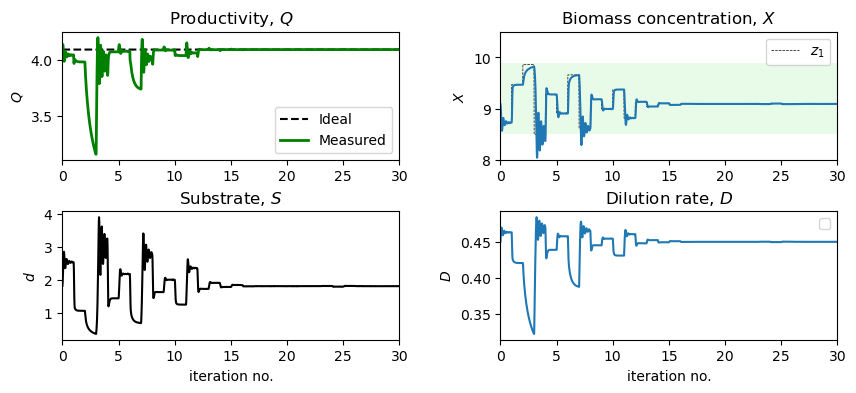

In [5]:
import matplotlib.gridspec as gridspec

# Create a 2x2 plot layout with each subplot 3x longer than tall
fig = plt.figure(figsize=(10, 4))  # Aspect ratio of 3x1 for each subplot
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, wspace=0.3, hspace=0.4)

iter = np.linspace(0,30,1500)
ax1 = fig.add_subplot(spec[0, 0])  # Top-left
ax2 = fig.add_subplot(spec[0, 1])  # Top-right
ax4 = fig.add_subplot(spec[1, 0])  # Bottom-left
ax3 = fig.add_subplot(spec[1, 1])  # Bottom-right

# First subplot
ax1.plot(iter,Joptt, 'k--', linewidth=1.5, label='Ideal')
ax1.plot(iter,Jt, 'g', linewidth=2, label='Measured')
ax1.set_ylabel('$Q$')
ax1.set_xlim([0, 30])
#ax1.set_ylim([2.5, 4.5])
ax1.legend()
ax1.set_title('Productivity, $Q$')

# Second subplot
ax2.plot(iter,xspt, 'k--', linewidth=0.5, label='$z_1$')
ax2.plot(iter,xt, linewidth=1.5)
ax2.set_ylabel('$X$')
ax2.set_ylim([8, 10.5])
ax2.set_xlim([0, 30])
#ax2.set_yticks([-8, -4, 0, 4])
ax2.axhspan(8.5, 9.9, facecolor='lightgreen', alpha=0.2)
ax2.legend()
ax2.set_title('Biomass concentration, $X$')

# Third subplot (Bottom-left)
#ax3.plot(y2spt, 'k--', linewidth=0.5, label='$z_2$')
ax3.plot(iter,Dt, linewidth=1.5)
ax3.set_ylabel('$D$')
#ax3.set_ylim([-8, 4])
ax3.set_xlim([0, 30])
ax3.set_xlabel('iteration no.')
#ax3.set_yticks([-8, -4, 0, 4])
#ax3.axhspan(-8, 0, facecolor='lightgreen', alpha=0.2)
ax3.legend()
ax3.set_title('Dilution rate, $D$')

# Fourth subplot (Bottom-right)
ax4.plot(iter,St, 'k', linewidth=1.5)
ax4.set_ylabel('$d$')
#ax4.set_ylim([-2, 2.5])
ax4.set_xlim([0, 30])
ax4.set_title('Substrate, $S$')
ax4.set_xlabel('iteration no.')
fig.savefig('Ex4_ts.pdf',bbox_inches='tight')
# Display the plot
plt.show()

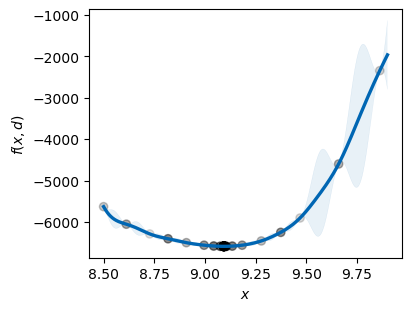

In [6]:
#J_Obj.fit_gp()
J_Obj.plot_GP_context(X_sample=Z_sample,Y_sample=J_sample)


D: 0.07, Steady-State Biomass (x): 9.9794 kg/m³, Steady-State Substrate (s): 0.0331 kg/m³
D: 0.08, Steady-State Biomass (x): 9.9753 kg/m³, Steady-State Substrate (s): 0.0387 kg/m³
D: 0.09, Steady-State Biomass (x): 9.9764 kg/m³, Steady-State Substrate (s): 0.0445 kg/m³
D: 0.10, Steady-State Biomass (x): 9.9747 kg/m³, Steady-State Substrate (s): 0.0506 kg/m³
D: 0.11, Steady-State Biomass (x): 9.9702 kg/m³, Steady-State Substrate (s): 0.0571 kg/m³
D: 0.12, Steady-State Biomass (x): 9.9704 kg/m³, Steady-State Substrate (s): 0.0638 kg/m³
D: 0.13, Steady-State Biomass (x): 9.9642 kg/m³, Steady-State Substrate (s): 0.0710 kg/m³
D: 0.14, Steady-State Biomass (x): 9.9630 kg/m³, Steady-State Substrate (s): 0.0785 kg/m³
D: 0.15, Steady-State Biomass (x): 9.9536 kg/m³, Steady-State Substrate (s): 0.0866 kg/m³
D: 0.16, Steady-State Biomass (x): 9.9520 kg/m³, Steady-State Substrate (s): 0.0950 kg/m³
D: 0.17, Steady-State Biomass (x): 9.9479 kg/m³, Steady-State Substrate (s): 0.1040 kg/m³
D: 0.18, S

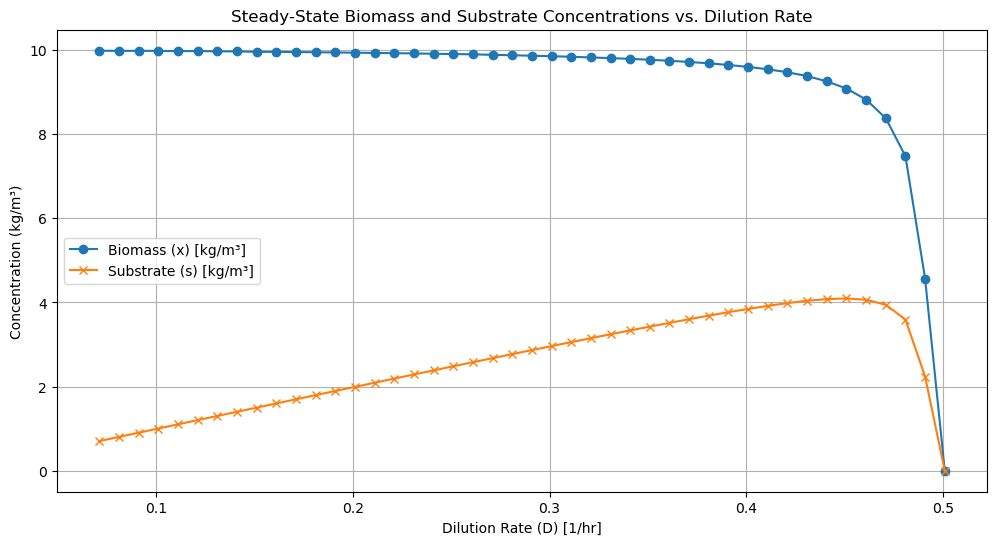

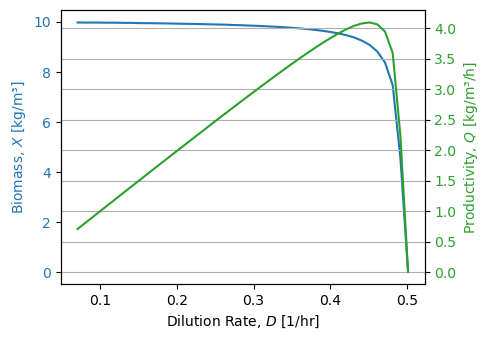

In [7]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Parameters based on the provided table
mu_max = 0.5        # Maximum specific growth rate (1/hr)
Y_xs = 0.5          # Biomass yield from substrate (kg/kg)
K_s = 0.2           # Substrate constant (kg/m^3)
s_in = 20.0         # Inlet substrate concentration (kg/m^3)

# Define the objective function for optimization
def steady_state_objective(vars, D, mu_max, K_s, Y_xs, s_in):
    x, s = vars
    mu = mu_max * s / (K_s + s)  # Specific growth rate (Monod equation)
    
    # Steady-state equations residuals
    eq1 = (mu - D) * x           # dx/dt = 0
    eq2 = D * (s_in - s) - (mu * x) / Y_xs  # ds/dt = 0
    
    # Objective is to minimize the sum of squared residuals
    return eq1**2 + eq2**2

# Initial guesses for x and s
initial_guess = [10, 0.50]

# Lists to store results
D_values = np.arange(0.071, 0.502, 0.01)  # Dilution rates from 0 to 1 in steps of 0.05
x_steady_values = []
s_steady_values = []

# Loop over each value of D
for D in D_values:
    # Minimize the sum of squared residuals of the steady-state equations
    result = minimize(
        steady_state_objective, 
        initial_guess, 
        args=(D, mu_max, K_s, Y_xs, s_in),
        method='SLSQP',  # A robust method that doesn't need derivatives
        bounds=[(0, None), (0, s_in)]  # Biomass and substrate should be positive
    )
    
    # Extract solutions
    x_steady, s_steady = result.x
    
    # Store the results
    x_steady_values.append(x_steady)
    s_steady_values.append(s_steady)

# Print the results
for D, x_steady, s_steady in zip(D_values, x_steady_values, s_steady_values):
    print(f"D: {D:.2f}, Steady-State Biomass (x): {x_steady:.4f} kg/m³, Steady-State Substrate (s): {s_steady:.4f} kg/m³")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(D_values, x_steady_values, label='Biomass (x) [kg/m³]', marker='o')
plt.plot(D_values, D_values*x_steady_values, label='Substrate (s) [kg/m³]', marker='x')
plt.xlabel('Dilution Rate (D) [1/hr]')
plt.ylabel('Concentration (kg/m³)')
plt.title('Steady-State Biomass and Substrate Concentrations vs. Dilution Rate')
plt.legend()
plt.grid(True)
plt.show()

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(5, 3.5))

color = 'tab:blue'
ax1.set_xlabel('Dilution Rate, $D$ [1/hr]')
ax1.set_ylabel('Biomass, $X$ [kg/m³]', color=color)
ax1.plot(D_values, x_steady_values, label='Biomass (x) [kg/m³]', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for substrate
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Productivity, $Q$ [kg/m³/h]', color=color)
ax2.plot(D_values, D_values * x_steady_values, label='Productivity Q [kg/m³/h]', color=color)
ax2.tick_params(axis='y', labelcolor=color)

#plt.title('Steady-State Biomass and Substrate Concentrations vs. Dilution Rate')
fig.tight_layout()
plt.grid(True)
fig.savefig('Biomass.pdf',bbox_inches='tight')
plt.show()
